In [1]:
import sys
import numpy as np 
import pandas as pd 

package_paths = [
    '/kaggle/input/m5-forecasting',
]

for pth in package_paths:
    sys.path.append(pth)
    
    
import os
for dirname, _, filenames in os.walk('/kaggle/input/m5-forecasting-accuracy/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


# 1️⃣ Load Data

In [2]:
df_train = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
df_test = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
df_price = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
df_calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
df_price_calendar = df_price.merge(df_calendar[['d','wm_yr_wk']], on=['wm_yr_wk'], how='inner')
df_price_calendar = df_price_calendar.rename(columns={'d':'period'})

In [5]:
df_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
df1 = df_train.query('id=="HOBBIES_1_001_CA_1_validation"')

# 2️⃣ Plotting sales of random ids

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt


def pivot_timeseries(df, id_cols, val_stub):
    df_pivot = pd.wide_to_long(df, val_stub, id_cols, 'd').rename(columns={val_stub:'target'}).reset_index()
    df_pivot['d'] = 'd_' + df_pivot['d'].astype(str)
    df_pivot = df_pivot.set_index('d')
    return df_pivot

def plot_sales(df, timeseries_id=None):
    
    id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    
    if timeseries_id is None:
        print("Sampling random time series...")
        timeseries_id = df['id'].sample(1).values[0]
        print(f"Timeseries id: {timeseries_id}")
    
    print("Pivoting data")
    df_plot = df.query(f'id=="{timeseries_id}"')
    df_plot = pivot_timeseries(df_plot, id_cols, 'd_')
            
    sns.set(rc={'figure.figsize':(30,4)})
    print("Plotting data")
    sns.lineplot(y='target', x='d', data=df_plot.reset_index())
    plt.title(f"Sales for {timeseries_id}")
    
    return df_plot

Pivoting data
Plotting data


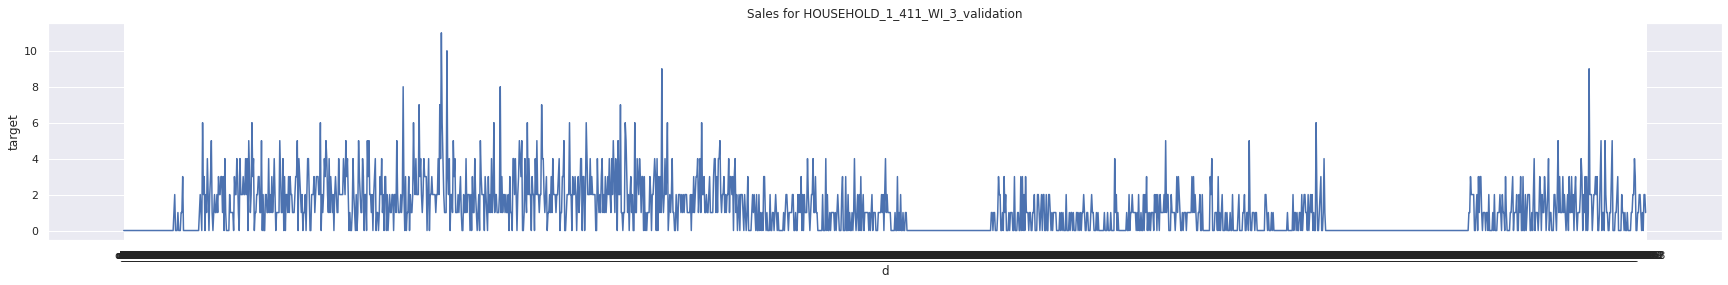

In [36]:
x = plot_sales(df_train, timeseries_id="HOUSEHOLD_1_411_WI_3_validation")

This timeseries is characterised by 3 short 'offline' periods where there is consistently no sales for long periods, likely because product isn't available at the store over those periods. The 3 online periods have different 'averages' - the first period has average sales of ~ 4 whilst in latter periods it's averaging around 2.

Pivoting data
Plotting data


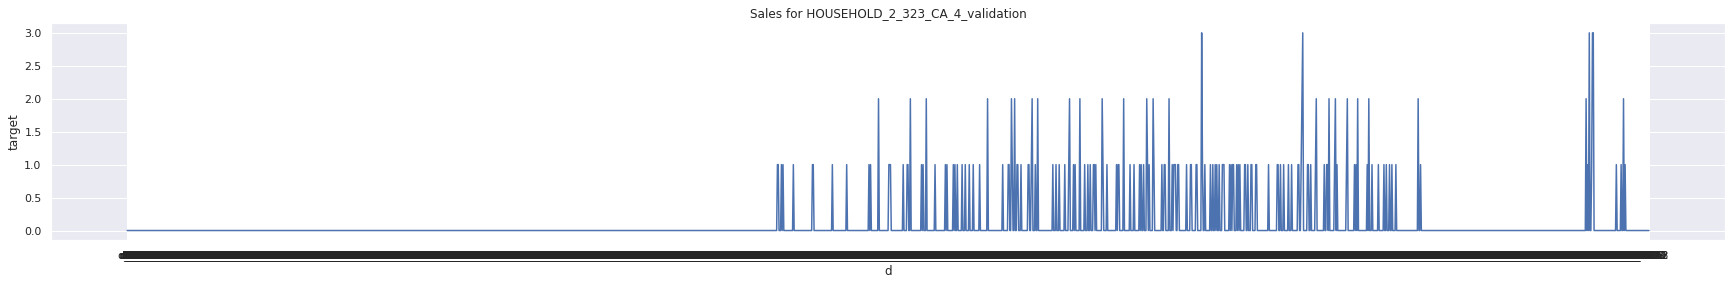

In [39]:
y = plot_sales(df_train, timeseries_id='HOUSEHOLD_2_323_CA_4_validation')

In [54]:
dfy = y.query('target>0').reset_index()
dfy['time'] = dfy['d'].apply(lambda x: x.split('_')[1]).astype(int)
dfy['time'].min()

818

This timeseries is characterised by 2 'offline' periods - the first period however is very long - sales only went online on/ after d_818. It then went offline again for a short period before coming online again.

Sampling random time series...
Timeseries id: HOUSEHOLD_2_473_CA_3_validation
Pivoting data
Plotting data


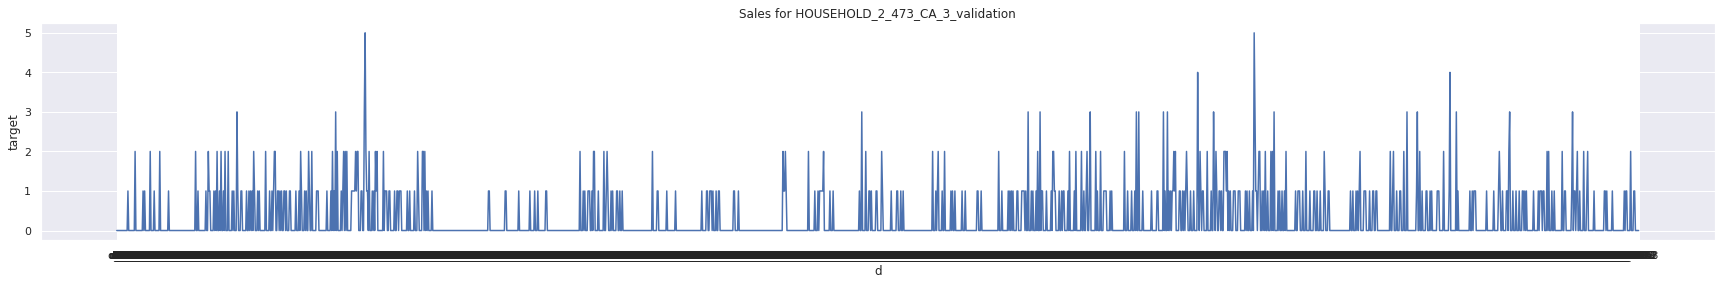

In [35]:
z = plot_sales(df_train)

This time series is characterised by very short 'offline' periods - but product is online most of the time over the period.

### TL;DR
- Clearly to avoid biasing forecasts, we should remove all time periods where product is offline/ or at least only include periods after product went online for the first time.
- For example, we should only include data on/after `d_818` for id=`HOUSEHOLD_2_323_CA_4_validation`.
- For id=`HOUSEHOLD_1_411_WI_3_validation`, we would exclude the first short 'offline' period but include the next 2 offline period as it's difficult to extract all intermediate offline periods.
- Over the evaluation period, we would assume that all products are 'online' as we have no information on whether or not a product would be online.

# 3️⃣ Analyse Sales by seasonality

In [84]:
df_calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [123]:
id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
df50 = pivot_timeseries(df_train.sample(50), id_cols, 'd_').reset_index()
df50 = df50.merge(df_calendar, on='d', how='left')
df50['event_name_1_true'] = df50['event_name_1'].notna().astype(int)
df50['event_name_2_true'] = df50['event_name_2'].notna().astype(int)
df50['event_name_num'] = df50['event_name_1_true'] + df50['event_name_2_true']
df50['time'] = df50['d'].apply(lambda x: x.split('_')[1]).astype(int)

df_min_time = df50.query('target>0').groupby(id_cols)[['time']].min().reset_index().rename(columns={'time':'min_time'})
df50 = df50.merge(df_min_time, on=id_cols, how='left')
df50 = df50.query('time >= min_time') # filter out initial non-zero periods


df50

,d,item_id,dept_id,cat_id,store_id,state_id,id,target,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,event_name_1_true,event_name_2_true,event_name_num,time,min_time
556,d_557,HOBBIES_1_349,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_349_CA_4_validation,1,2012-08-07,11228,...,NaN,NaN,1,1,0,0,0,0,557,557
557,d_558,HOBBIES_1_349,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_349_CA_4_validation,0,2012-08-08,11228,...,NaN,NaN,1,0,1,0,0,0,558,557
558,d_559,HOBBIES_1_349,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_349_CA_4_validation,0,2012-08-09,11228,...,NaN,NaN,1,1,1,0,0,0,559,557
559,d_560,HOBBIES_1_349,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_349_CA_4_validation,0,2012-08-10,11228,...,NaN,NaN,1,0,0,0,0,0,560,557
560,d_561,HOBBIES_1_349,HOBBIES_1,HOBBIES,CA_4,CA,HOBBIES_1_349_CA_4_validation,0,2012-08-11,11229,...,NaN,NaN,0,1,1,0,0,0,561,557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95645,d_1909,FOODS_3_474,FOODS_3,FOODS,WI_2,WI,FOODS_3_474_WI_2_validation,2,2016-04-20,11612,...,NaN,NaN,0,0,0,0,0,0,1909,432
95646,d_1910,FOODS_3_474,FOODS_3,FOODS,WI_2,WI,FOODS_3_474_WI_2_validation,4,2016-04-21,11612,...,NaN,NaN,0,0,0,0,0,0,1910,432
95647,d_1911,FOODS_3_474,FOODS_3,FOODS,WI_2,WI,FOODS_3_474_WI_2_validation,4,2016-04-22,11612,...,NaN,NaN,0,0,0,0,0,0,1911,432
95648,d_1912,FOODS_3_474,FOODS_3,FOODS,WI_2,WI,FOODS_3_474_WI_2_validation,15,2016-04-23,11613,...,NaN,NaN,0,0,0,0,0,0,1912,432


In [114]:
df50[(df50['wm_yr_wk'] < 11210) & (df50['wm_yr_wk'] >11100)]['wm_yr_wk'].unique()

array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
       11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
       11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
       11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
       11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11201, 11202,
       11203, 11204, 11205, 11206, 11207, 11208, 11209])

<AxesSubplot:xlabel='wm_yr_wk', ylabel='target'>

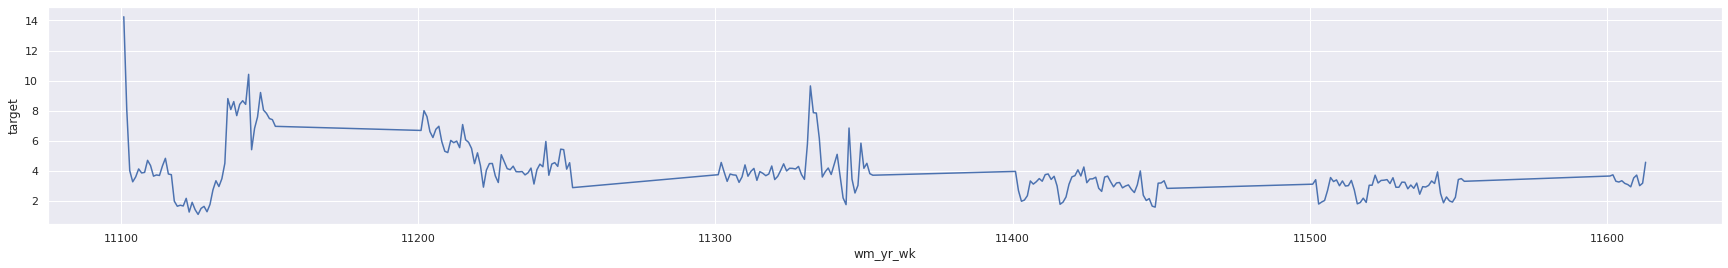

In [124]:
dftime = df50.groupby(['wm_yr_wk'])[['target']].mean().reset_index()
sns.lineplot(x='wm_yr_wk', y='target', data=dftime)

Sales in year 2011 have very high average sales, but in the later years average sales is a lot more stable. Particularly in the latyer 2 years - average sales have very similar 'patterns' - 3 very low trough and 2 periods of consistently 'high' sales.

<AxesSubplot:xlabel='wday', ylabel='target'>

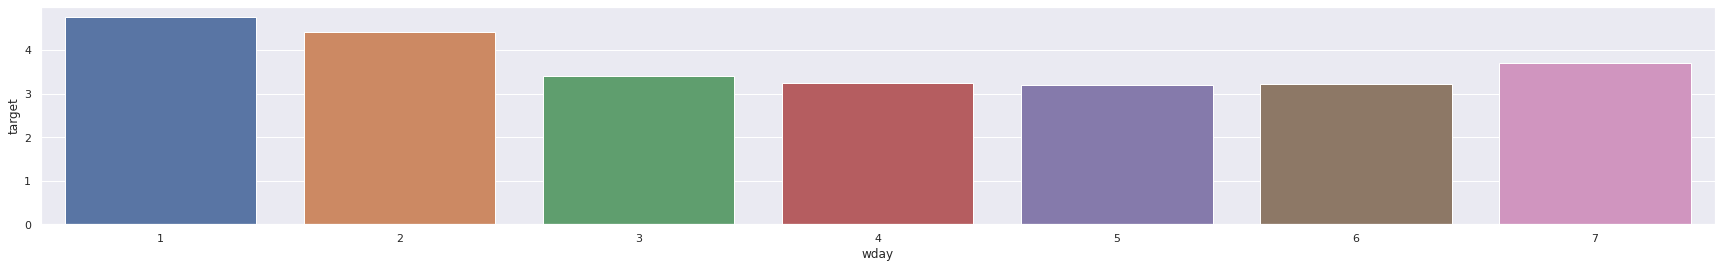

In [125]:
dfx = df50.groupby(['wday'])[['target']].mean().reset_index()
sns.barplot(x='wday', y='target', data=dfx)

Sales on wday == 1, 2 and 7 is higher than on average.

<AxesSubplot:xlabel='event_name_num', ylabel='target'>

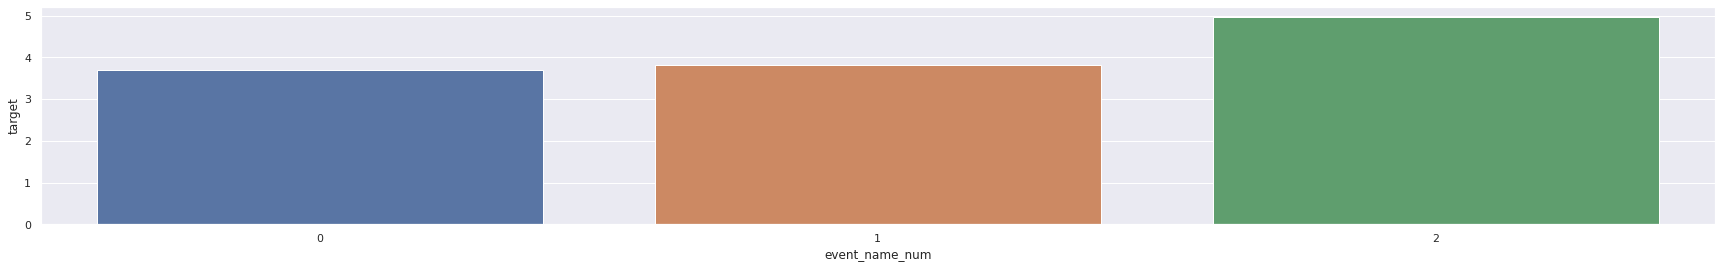

In [126]:
dfx = df50.groupby(['event_name_num'])[['target']].mean().reset_index()
sns.barplot(x='event_name_num', y='target', data=dfx)

Sales on double holidays are significantly higher than sales with 0 or only holidays.

<AxesSubplot:xlabel='month', ylabel='target'>

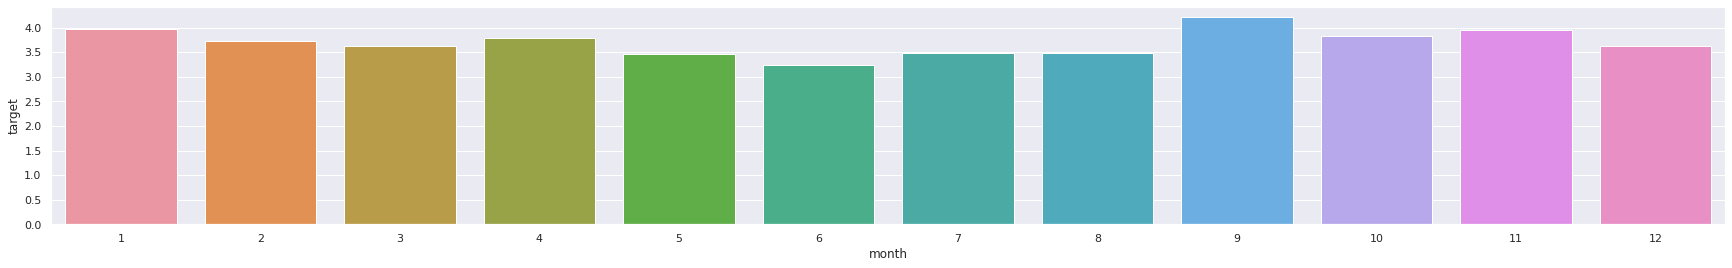

In [128]:
dfx = df50.groupby(['month'])[['target']].mean().reset_index()
sns.barplot(x='month', y='target', data=dfx)

Average sales is low during summer and december.

### Sales by product ids

<AxesSubplot:xlabel='dept_id', ylabel='target'>

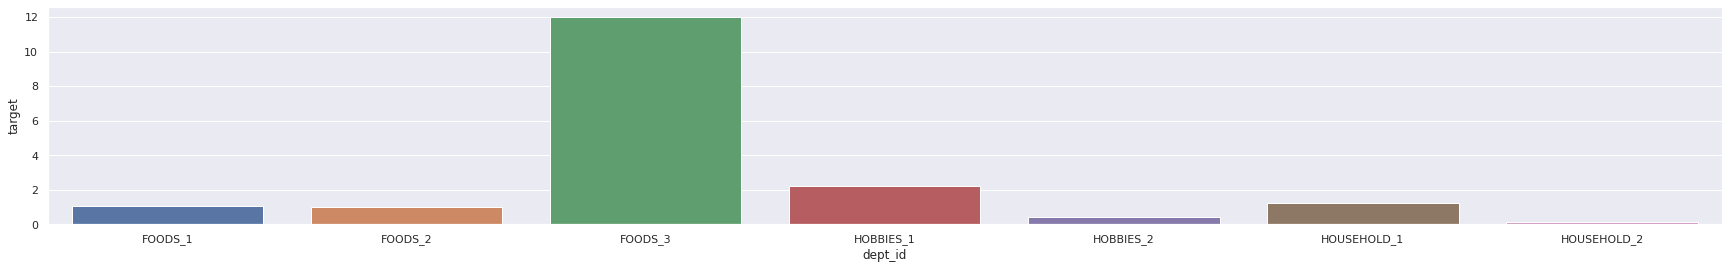

In [129]:
dfx = df50.groupby(['dept_id'])[['target']].mean().reset_index()
sns.barplot(x='dept_id', y='target', data=dfx)

FOODS_3 has the highest average of sales compared to other dept_id

<AxesSubplot:xlabel='cat_id', ylabel='target'>

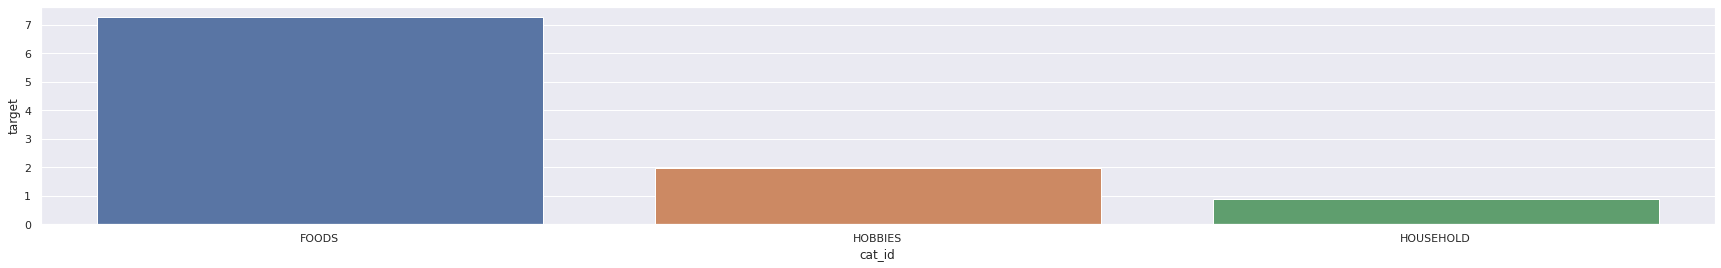

In [130]:
dfx = df50.groupby(['cat_id'])[['target']].mean().reset_index()
sns.barplot(x='cat_id', y='target', data=dfx)

FOODS has the highest average sales compared to other categories, probably driven by FOODS_3!

<AxesSubplot:xlabel='store_id', ylabel='target'>

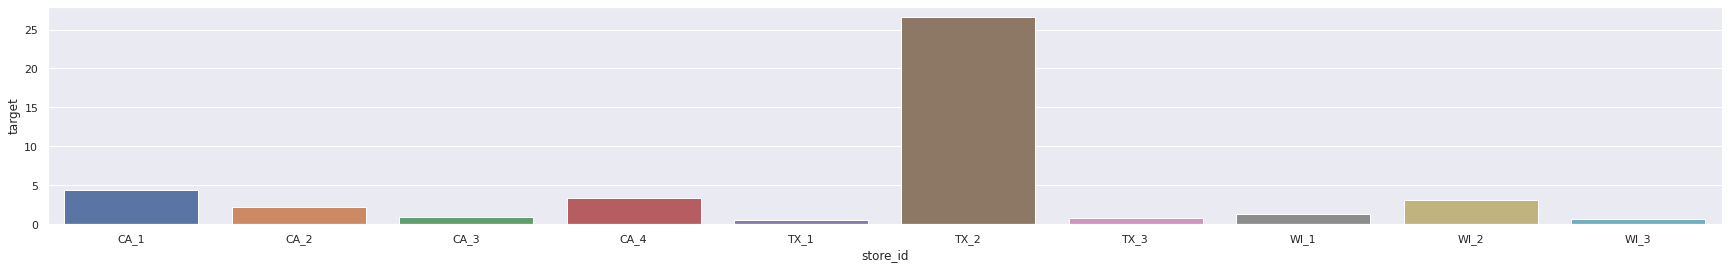

In [131]:
dfx = df50.groupby(['store_id'])[['target']].mean().reset_index()
sns.barplot(x='store_id', y='target', data=dfx)

TX_2 has the highest average sales compared to other stores.

### TL;DR
- Sales show signs of seasonality by days of week and month of year
- There's some correlation between sales and holidays
- Average sales are the highest for FOOD_3 and TX_2
- We could potentially exclude sales prior of periods wm_yr_wk < 11400
- We should also try to exclude sales data from before product first went on sales to avoid the dead 'zero' offline period - this will severely affect performance against 'naive' forecaster because naive forecaster takes 'last known values' which would be robust against the intermittent zero periods